In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
train_dir = '/home/adesoji/Downloads/Vehicle_Classification_Model_Images/Train'
val_dir = '/home/adesoji/Downloads/Vehicle_Classification_Model_Images/validation'


In [2]:
#train_dir = '/content/drive/MyDrive/Mask_dataset/train'
#val_dir = '/content/drive/MyDrive/Mask_dataset/validation'

In [3]:

BATCH_SIZE = 64
IMG_SIZE = (96, 96)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 3204 files belonging to 2 classes.
Found 1376 files belonging to 2 classes.


In [4]:
class_names = train_dataset.class_names
class_names

['Bad_cars', 'Good_cars']

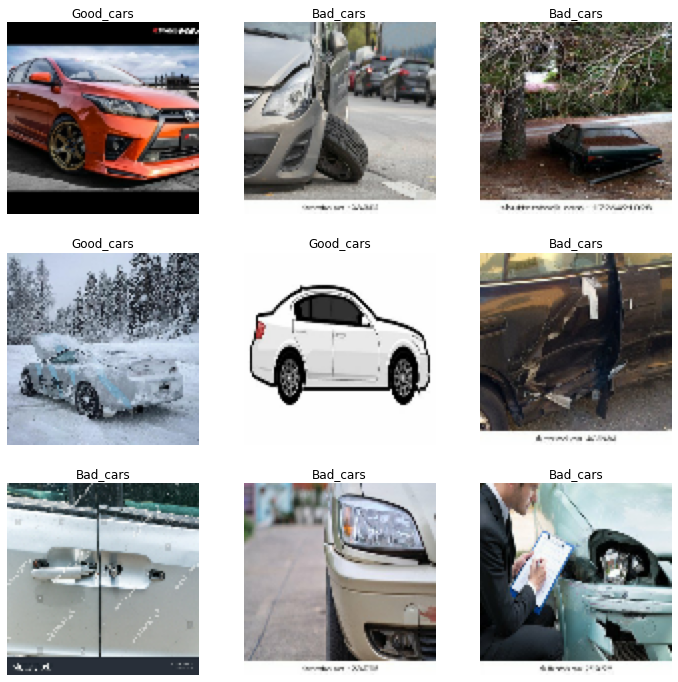

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(12,12))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset= validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('number of validation batches: %d' %tf.data.experimental.cardinality
      (validation_dataset))
print('number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

number of validation batches: 18
number of test batches: 4


In [6]:
AUTOTUNE =  tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [7]:
data_augmentation = tf.keras.Sequential([
       tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
       tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)                                  
])

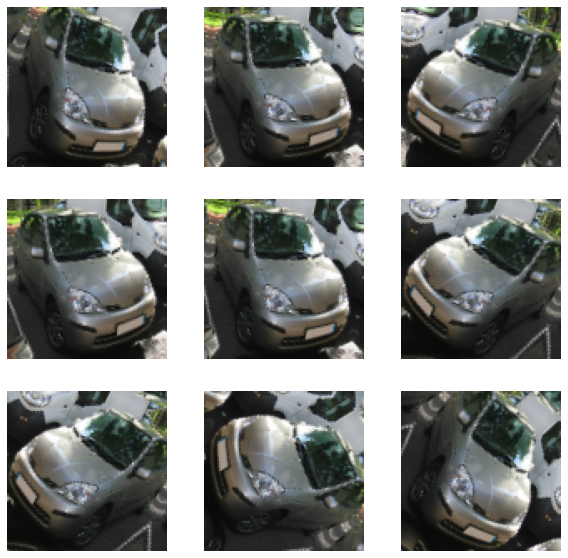

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [17]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [18]:
IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')


In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1280)


In [20]:
base_model.trainable = False

In [21]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [24]:
inputs = tf.keras.Input(shape=(96,96,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

/home/adesoji/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [27]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))


18/18 [==============================] - 15s 506ms/step - loss: 0.9086 - accuracy: 0.4563
initial loss: 0.91
initial accuracy: 0.46


In [28]:
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor='val_accuracy', patience= 2, mode = 'max', min_delta = 1, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


In [33]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

Epoch 1/20
51/51 [==============================] - 30s 570ms/step - loss: 0.3535 - accuracy: 0.8424 - val_loss: 0.4354 - val_accuracy: 0.8152
Epoch 2/20
51/51 [==============================] - 20s 365ms/step - loss: 0.3572 - accuracy: 0.8405 - val_loss: 0.4095 - val_accuracy: 0.8277
Epoch 3/20
51/51 [==============================] - 18s 331ms/step - loss: 0.3467 - accuracy: 0.8430 - val_loss: 0.4282 - val_accuracy: 0.8196
Epoch 4/20
51/51 [==============================] - 17s 323ms/step - loss: 0.3560 - accuracy: 0.8393 - val_loss: 0.4264 - val_accuracy: 0.8277
Epoch 5/20
51/51 [==============================] - 18s 327ms/step - loss: 0.3411 - accuracy: 0.8499 - val_loss: 0.4018 - val_accuracy: 0.8357
Epoch 6/20
51/51 [==============================] - 18s 334ms/step - loss: 0.3478 - accuracy: 0.8461 - val_loss: 0.4123 - val_accuracy: 0.8321
Epoch 7/20
51/51 [==============================] - 18s 345ms/step - loss: 0.3412 - accuracy: 0.8511 - val_loss: 0.4117 - val_accuracy: 0.8339

In [34]:
model.evaluate(train_dataset)

51/51 [==============================] - 21s 372ms/step - loss: 0.3827 - accuracy: 0.8552


[0.3827163279056549, 0.8551810383796692]

In [39]:
model.evaluate(validation_dataset)

35/35 [==============================] - 6s 125ms/step - loss: 0.3672 - accuracy: 0.8661


[0.36715471744537354, 0.8660714030265808]

In [28]:
!pip install pyyaml h5py

You should consider upgrading via the '/home/adesoji/Videos/ENTER/bin/python -m pip install --upgrade pip' command.


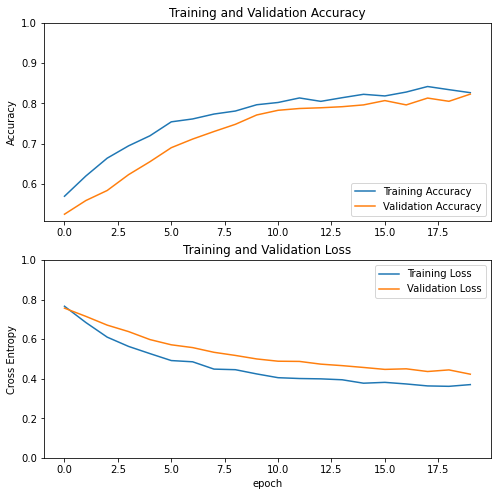

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
model.save('vehicle_detection.h5')

/home/adesoji/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Predictions:
 [0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0
 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 1]
Labels:
 [0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0
 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1]


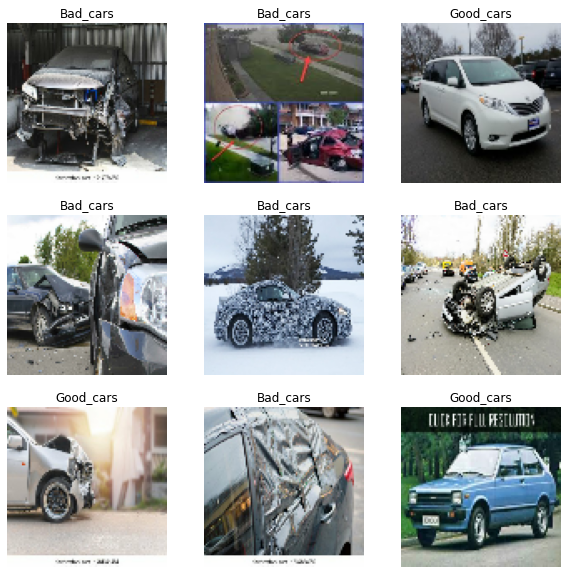

In [32]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [36]:
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(96, 96))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " without nose mask")
  else:
    print(fn + " with nose mask")

Saving doctor-with-mask-stethoscope-coronavirus-prevention_23-2148463060.jpg to doctor-with-mask-stethoscope-coronavirus-prevention_23-2148463060.jpg
[-2.6094677]
doctor-with-mask-stethoscope-coronavirus-prevention_23-2148463060.jpg with nose mask


This image is -209.58 percent Bad_car and 309.58 percent Good_car.


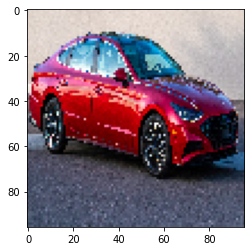

In [44]:
image_size = (96,96)
img = tf.keras.preprocessing.image.load_img(
    "/home/adesoji/Downloads/SONATA-hero-option1-764A5360-edit.jpg", target_size=image_size
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Bad_car and %.2f percent Good_car."
    % (100 * (1 - score), 100 * score)
)
plt.imshow(img)


This image is 240.62 percent Bad_car and -140.62 percent Good_car.


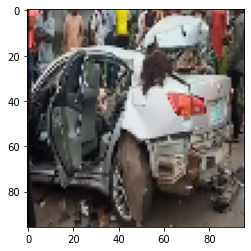

In [45]:
image_size = (96,96)
img = tf.keras.preprocessing.image.load_img(
    "/home/adesoji/Downloads/_119337730_ntaroadaccidentaccidentforportharcourtleadtodeathfivefortrafficcollision.jpeg", target_size=image_size
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Bad_car and %.2f percent Good_car."
    % (100 * (1 - score), 100 * score)
)
plt.imshow(img)